# Speaker Identification
This experiment will be to determine if the design from music classification can also be used for speaker identification.

In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pathlib
import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Keras
import keras

## Dataset
I will include the code below for creating the dataset from librispeech train-clean-100, in case of making alterations or additions to it. This is a lengthy process and will take a while to run, so I am also including the preprocessed data file in the directory so this step can be skipped. 

In [53]:
#path to libriSpeech
path = 'C:/Users/Owner/Desktop/speechData/LibriSpeech'
speaker_index = path+'/SPEAKERS.TXT'
file = open(speaker_index)

speakerID = []
speakerSex = []

for line in file.readlines():
    if line[0] == ';':
        continue
    else:
        l = line.split('|')
        for j in range(len(l)):
            l[j] = l[j].strip()
        if l[2] == 'train-clean-100':
            speakerID.append(l[0])
            speakerSex.append(l[1])
file.close()
path = path + '/train-clean-100/'
print('TOTAL SPEAKERS:')
print(len(speakerID))

TOTAL SPEAKERS:
251


In [51]:
#load data

#define mesurements
n_fft = 2048
hop_len = 512

def generate_mfcc_data(n_mfcc,duration):
    header = 'filename zero_crossing_rate spectral_rolloff spectral_centroid spectral_bandwidth spectral_contrast rmse'
    for i in range(1, n_mfcc+1):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file_n = 'mfcc_data_'+str(n_mfcc)+'.csv'
    file = open(file_n, 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    
    for s in speakerID:
        for file in os.listdir(path+s):
            sp = path+s+'/'+file
            for audio in os.listdir(sp):
                if audio.endswith('.flac'):
                    sample = sp+'/'+audio
                    y, sr = librosa.load(sample, mono=True, duration=duration)
                    mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=n_mfcc,n_fft=n_fft,hop_length=hop_len)
                    zcr = librosa.feature.zero_crossing_rate(y)
                    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
                    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
                    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
                    spec_con = librosa.feature.spectral_contrast(y=y, sr=sr,n_fft=n_fft,hop_length=hop_len)
                    rmse = librosa.feature.rms(y)                                             
                    to_append = f'{audio} {np.mean(zcr)} {np.mean(rolloff)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(spec_con)} {np.mean(rmse)}'    

                    for c in mfcc:
                        to_append += f' {np.mean(c)}'
                    to_append += f' {s}'
                    file = open(file_n, 'a', newline='')
                    with file:
                        writer = csv.writer(file)
                        writer.writerow(to_append.split())
            file.close()

#generate_mfcc_data(24,30)

In [2]:
data = pd.read_csv('mfcc_data_24.csv')
data = data.drop(['filename'],axis=1)
speaker_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(speaker_list)
scaler = StandardScaler()
x = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2) #this also shuffles

data.head()

,zero_crossing_rate,spectral_rolloff,spectral_centroid,spectral_bandwidth,spectral_contrast,rmse,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,mfcc21,mfcc22,mfcc23,mfcc24,label
0,0.086363,3507.125460,1778.355543,1692.786252,23.776870,0.033452,-341.305450,117.004158,-37.202362,41.383190,...,-3.301497,0.186295,-7.219159,3.745861,2.832097,0.349585,8.161204,-3.047781,7.935079,19
1,0.097548,3469.797493,1798.721466,1647.499914,24.039903,0.039666,-323.179108,116.387230,-26.431742,42.178349,...,-4.273248,-0.183986,-6.536091,1.953721,3.308642,1.082314,5.086967,-1.756058,7.098583,19
2,0.100296,3237.528667,1736.256627,1546.480740,24.972923,0.046465,-294.916199,124.810066,-34.847099,37.510292,...,-8.786871,-3.179496,-3.961694,1.185579,1.386576,-0.486062,3.593568,-2.342621,7.645415,19
3,0.108680,3551.897013,1868.086606,1639.712330,24.477583,0.042632,-309.100525,114.900864,-31.439497,38.726517,...,-8.132153,-0.190700,-4.110128,0.972584,1.981013,1.084483,4.984741,-1.885651,8.266959,19
4,0.089507,3453.156738,1753.622751,1645.746706,23.842915,0.036654,-341.987030,108.964302,-22.190104,32.606213,...,-2.710757,-1.301947,-2.293156,2.266790,1.768415,3.721497,4.954425,0.938724,8.927581,19


In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(251, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
EPOCHS=5
H = model.fit(x_train,
              y_train,
              epochs=EPOCHS,
              batch_size=100,
              validation_data=(x_val, y_val))

Epoch 1/5
229/229 [==============================] - 1s 3ms/step - loss: 2.1794 - sparse_categorical_accuracy: 0.5353 - val_loss: 0.4235 - val_sparse_categorical_accuracy: 0.8889
Epoch 2/5
229/229 [==============================] - 1s 3ms/step - loss: 0.2292 - sparse_categorical_accuracy: 0.9412 - val_loss: 0.2043 - val_sparse_categorical_accuracy: 0.9446
Epoch 3/5
229/229 [==============================] - 1s 3ms/step - loss: 0.1123 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.1035 - val_sparse_categorical_accuracy: 0.9725
Epoch 4/5
229/229 [==============================] - 1s 3ms/step - loss: 0.0674 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.1200 - val_sparse_categorical_accuracy: 0.9672
Epoch 5/5
229/229 [==============================] - 1s 3ms/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9851 - val_loss: 0.1152 - val_sparse_categorical_accuracy: 0.9711


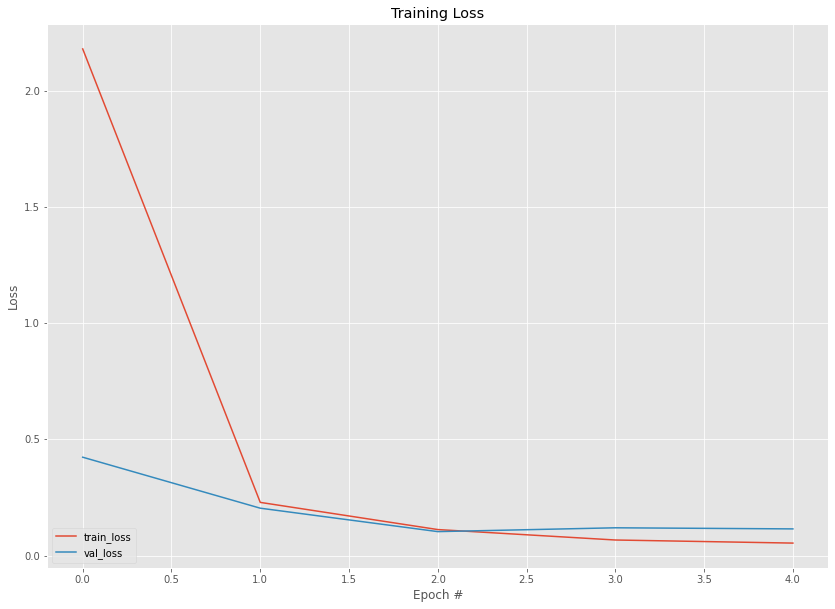

In [4]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(14,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

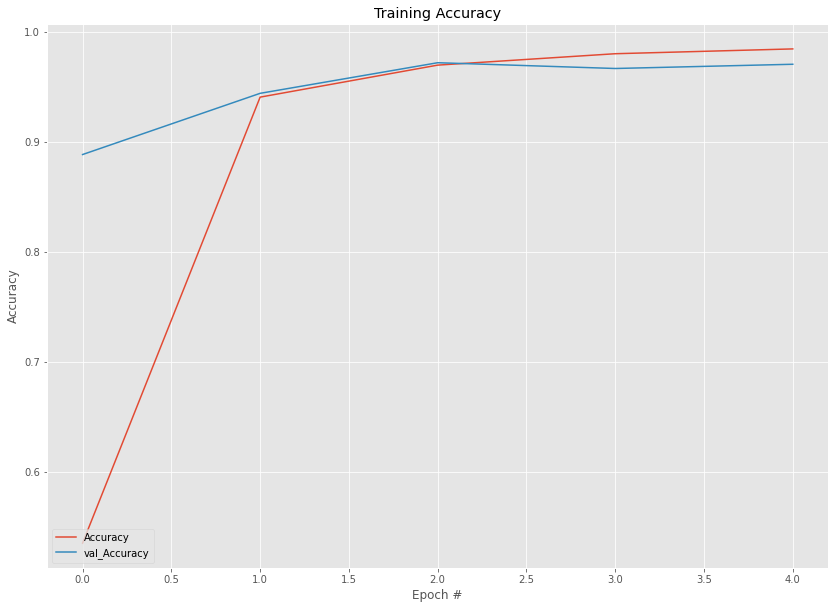

In [5]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(14,10))
plt.plot(N, H.history["sparse_categorical_accuracy"], label="Accuracy")
plt.plot(N, H.history["val_sparse_categorical_accuracy"], label="val_Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

The results are excellent ,and convergens occurs almost instantly. Next I will repeat the test but with less MFCC's and lets see what happens using only 5 seconds from each sample

In [54]:
generate_mfcc_data(12,5)

In [6]:
data = pd.read_csv('mfcc_data_12.csv')
data = data.drop(['filename'],axis=1)
speaker_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(speaker_list)
scaler = StandardScaler()
x = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2) #this also shuffles

data.head()

,zero_crossing_rate,spectral_rolloff,spectral_centroid,spectral_bandwidth,spectral_contrast,rmse,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,label
0,0.086363,3507.125460,1778.355543,1692.786252,23.776870,0.033452,-341.305450,117.004158,-37.202362,41.383190,-16.322794,3.341266,-23.201122,-2.441874,-10.176661,-1.405638,4.640406,1.783818,19
1,0.101728,3417.548625,1809.061321,1626.408966,24.670552,0.042586,-316.721649,114.968407,-26.360632,47.156303,-21.061686,-4.030426,-26.205322,-12.932408,-20.425869,-3.818157,4.644622,2.091906,19
2,0.097509,3161.044312,1717.776383,1521.271536,25.489822,0.055503,-275.020447,125.559807,-41.486572,39.116455,-24.516750,-2.468870,-31.914541,-15.683402,-17.206470,1.301582,4.977127,3.149004,19
3,0.105123,3436.190796,1821.325207,1597.250212,24.566155,0.048240,-291.389587,118.589592,-36.924149,40.036015,-22.356560,-0.766906,-31.060915,-16.568142,-11.481939,-1.199537,4.842431,4.873504,19
4,0.065660,3524.417114,1673.435176,1737.562420,22.607058,0.023797,-400.181274,103.082809,-12.477015,23.892294,-2.539683,-0.674091,-9.987226,-8.676563,-5.740046,0.234679,3.673174,6.897930,19


In [7]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(251, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
EPOCHS=10
H = model.fit(x_train,
              y_train,
              epochs=EPOCHS,
              batch_size=100,
              validation_data=(x_val, y_val))

Epoch 1/10
229/229 [==============================] - 1s 3ms/step - loss: 2.8843 - sparse_categorical_accuracy: 0.3652 - val_loss: 1.2123 - val_sparse_categorical_accuracy: 0.6615
Epoch 2/10
229/229 [==============================] - 1s 2ms/step - loss: 0.8740 - sparse_categorical_accuracy: 0.7517 - val_loss: 0.6947 - val_sparse_categorical_accuracy: 0.7906
Epoch 3/10
229/229 [==============================] - 1s 2ms/step - loss: 0.5635 - sparse_categorical_accuracy: 0.8326 - val_loss: 0.5558 - val_sparse_categorical_accuracy: 0.8301
Epoch 4/10
229/229 [==============================] - 1s 2ms/step - loss: 0.4224 - sparse_categorical_accuracy: 0.8735 - val_loss: 0.4755 - val_sparse_categorical_accuracy: 0.8532
Epoch 5/10
229/229 [==============================] - 1s 2ms/step - loss: 0.3540 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.3950 - val_sparse_categorical_accuracy: 0.8767
Epoch 6/10
229/229 [==============================] - 1s 2ms/step - loss: 0.2924 - sparse_categorica

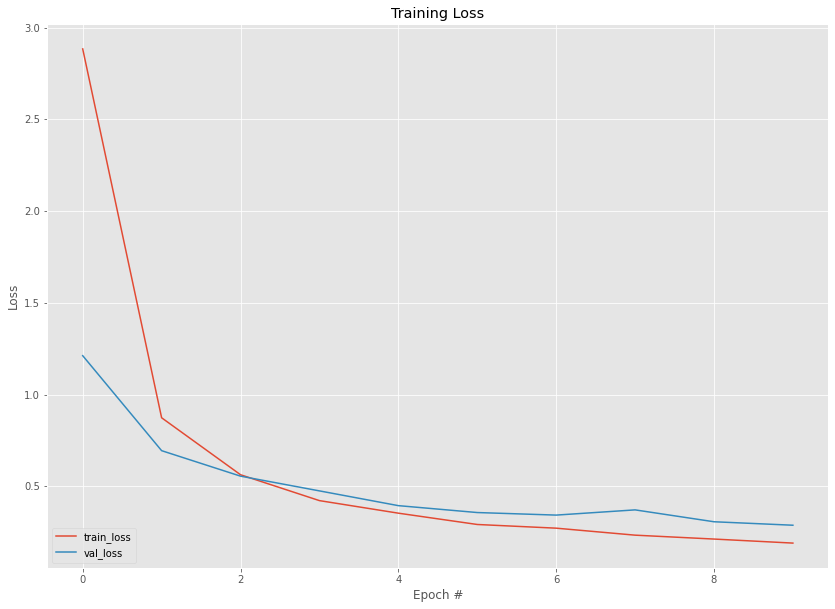

In [8]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(14,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

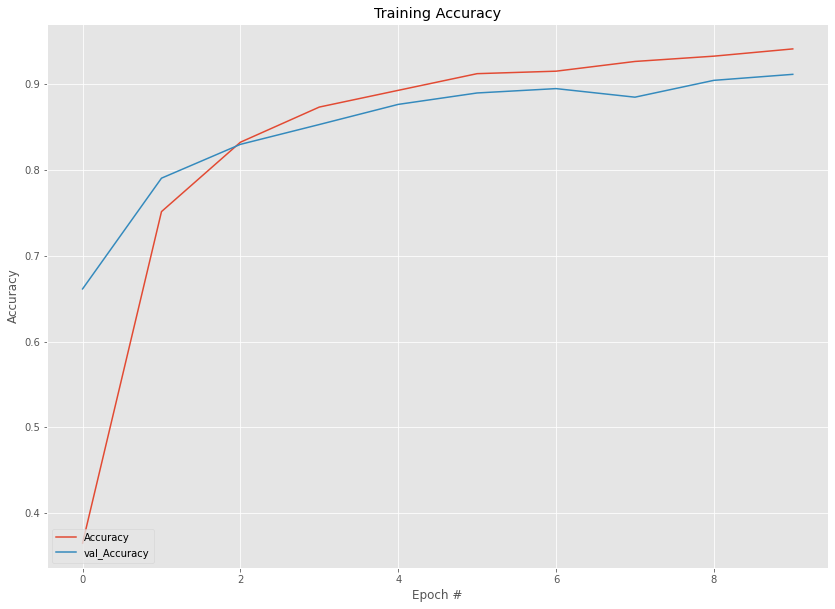

In [9]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(14,10))
plt.plot(N, H.history["sparse_categorical_accuracy"], label="Accuracy")
plt.plot(N, H.history["val_sparse_categorical_accuracy"], label="val_Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()